# Programming for Data Science and Artificial Intelligence

## 13 Neural Network from Scratch

### Readings

- [WEIDMAN] Ch1,2
- [CHARU] Ch1

### Foundations

Let's first consider the following neural network

![](figures/neuralnet1.png)

In [1]:
import numpy as np

np.random.seed(42)

#suppose we have datasets of three features, with three samples
X = np.random.randn(3, 3)

#let say our y has two output
W = np.random.randn(3, 2)

print("X:")
print(X)

print("W: ")
print(W)

X:
[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]]
W: 
[[ 0.54256004 -0.46341769]
 [-0.46572975  0.24196227]
 [-1.91328024 -1.72491783]]


### 1. The dot product

Dot product is simply an efficient way of multiplying each x with their corresponding weights.  The end result of dot product will be the predicted y

$$ \nu(X, W) = X * W = \begin{bmatrix}
x_{11} * w_{11} + x_{12} * w_{21} + x_{13} * w_{31} &
x_{11} * w_{12} + x_{12} * w_{22} + x_{13} * w_{32}
\\
x_{21} * w_{11} + x_{22} * w_{21} + x_{23} * w_{31} &
x_{21} * w_{12} + x_{22} * w_{22} + x_{23} * w_{32}
\\
x_{31} * w_{11} + x_{32} * w_{21} + x_{33} * w_{31} &
x_{31} * w_{12} + x_{32} * w_{22} + x_{33} * w_{32}
\end{bmatrix} = 
\begin{bmatrix}
XW_{11} &
XW_{12}
\\
XW_{21} &
XW_{22}
\\
XW_{31} &
XW_{32}
\end{bmatrix}
$$

In [2]:
print("X @ W")

assert X.shape[1] == W.shape[0]

N = X @ W
print(N)  #N is in shape X.shape[0], W.shape[1]

X @ W
[[-0.90531863 -1.38085038]
 [ 1.38335695 -0.35858825]
 [ 1.39763665  0.26365983]]


### 2. The activation function

Sometimes, the predicted y may not be in the form we need.  Activation function is a neaty way of mapping some values to a particular range we want.

Important characteristics of the activation function (commonly called sigma in general) is that it should be differentiable.  Why?  Because differentiable function will allow us to use descent algorithms to find the optimal w.

Text(0, 0.5, 'output')

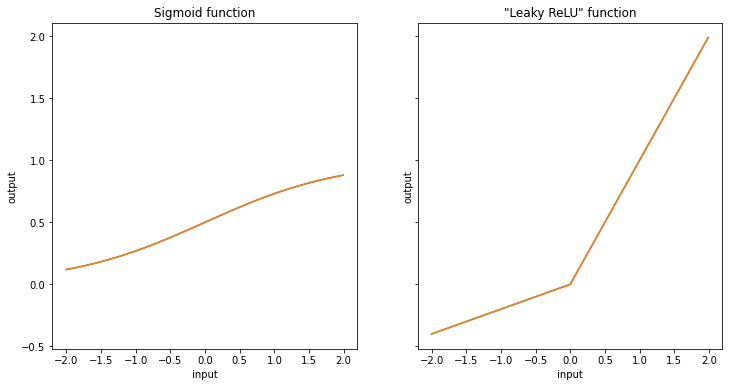

In [3]:
from numpy import ndarray
import matplotlib.pyplot as plt

def sigmoid(x: ndarray) -> ndarray:
    return 1 / (1 + np.exp(-x))

def leaky_relu(x: ndarray) -> ndarray:
    return np.maximum(0.2 * x, x)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))  # 1 Row, 2 Cols

input_range = np.arange(-2, 2, 0.01)
ax[0].plot(input_range, sigmoid(input_range))
ax[0].plot(input_range, sigmoid(input_range))
ax[0].set_title('Sigmoid function')
ax[0].set_xlabel('input')
ax[0].set_ylabel('output')

ax[1].plot(input_range, leaky_relu(input_range))
ax[1].plot(input_range, leaky_relu(input_range))
ax[1].set_title('"Leaky ReLU" function')
ax[1].set_xlabel('input')
ax[1].set_ylabel('output')


$$ 
\sigma(X * W) = \begin{bmatrix}
\sigma(x_{11} * w_{11} + x_{12} * w_{21} + x_{13} * w_{31}) &
\sigma(x_{11} * w_{12} + x_{12} * w_{22} + x_{13} * w_{32})
\\
\sigma(x_{21} * w_{11} + x_{22} * w_{21} + x_{23} * w_{31}) &
\sigma(x_{21} * w_{12} + x_{22} * w_{22} + x_{23} * w_{32})
\\
\sigma(x_{31} * w_{11} + x_{32} * w_{21} + x_{33} * w_{31}) &
\sigma(x_{31} * w_{12} + x_{32} * w_{22} + x_{33} * w_{32})
\end{bmatrix} = 
\begin{bmatrix}
\sigma(XW_{11}) & \sigma(XW_{12})\\
\sigma(XW_{21}) & \sigma(XW_{22})\\
\sigma(XW_{31}) & \sigma(XW_{32})
\end{bmatrix}
$$

In [4]:
sigma = sigmoid

S = sigma(N)
print("S: ")
print(S)

S: 
[[0.28795874 0.20087246]
 [0.7995296  0.41130135]
 [0.80180859 0.56553575]]


### 3. The Lambda function

Why do we need to sum all elements?

First, we know that we need to use descent algorithms to find the optimum value.  Let's say we want to find the gradient of S with respect to X and W.  What does gradient of one matrix with respect to another matrix mean?   Yes, it's actually difficult to think in that way.

Instead, for "gradient" to be well-defined, we need to sum (or perform any aggregations) into a single number so that "how much will changing each element of X affect the output".

Thus, we need a third lambda function that simply takes everything and sums up.  (Note again that there are other possible aggregation methods)

$$ L = \Lambda(\sigma(X * W)) = \Lambda(\begin{bmatrix}
\sigma(XW_{11}) & \sigma(XW_{12})\\
\sigma(XW_{21}) & \sigma(XW_{22})\\
\sigma(XW_{31}) & \sigma(XW_{32})
\end{bmatrix}) =  \sigma(XW_{11}) + \sigma(XW_{12}) + \sigma(XW_{21}) + \sigma(XW_{22}) + \sigma(XW_{31}) + \sigma(XW_{32})
$$

In [5]:
L = np.sum(S)

print(L)

3.067006496510426


### 4. Chain rule / Backpropagation

The question now is if we want to perform gradient descent, we must find derivatives.   Finding derivatives are easy, but how do we find derivatives of L with respect to X and W, when L is a result of series of transformations?

We can simply use the chain rule in Math.


First, let's define what is derivative, which can be expressed in a limit form as 

$$ \frac{df}{dx}(a) = 
\lim_{\Delta \to 0} \frac{{f \left( {a + \Delta } \right) - f\left( a - \Delta \right)}}{2 * \Delta } $$

In [6]:
from typing import Callable

#takes in ndarray and produces an ndarray
def deriv(func: Callable[[ndarray], ndarray],
          input_: ndarray,
          diff: float = 0.001) -> ndarray:
    '''
    Evaluates the derivative of a function "func" at every element in the "input_" array.
    '''
    return (func(input_ + diff) - func(input_ - diff)) / (2 * diff)

Second, let's learn about the chain rule, which is a mathematical theorem that lets us compute the derivatives of composite funtions.    Mathematically, the theorem states that for a given value x, 

$$ \frac{df_2}{dx}(x) = \frac{df_2}{du}(f_1(x)) * \frac{df_1}{dx}(x) $$

A pictorial explaination is given as follows:

Given the following composite function:

![](figures/chainrule1.png)

To find the gradient of y in respect to X, is simply the product of the gradients

![](figures/chainrule2.png)

In [7]:
from typing import List

# A Function takes in an ndarray as an argument and produces an ndarray
Array_Function = Callable[[ndarray], ndarray]

# A Chain is a list of functions
Chain = List[Array_Function]

In [8]:
def chain_length_2(chain: Chain,
                   x: ndarray) -> ndarray:
    '''
    Evaluates two functions in a row, in a "Chain".
    '''
    assert len(chain) == 2, "Length of input 'chain' should be 2"

    f1 = chain[0]
    f2 = chain[1]

    return f2(f1(x))

In [9]:
def chain_deriv_2(chain: Chain,
                  input_range: ndarray) -> ndarray:
    '''
    Uses the chain rule to compute the derivative of two nested functions:
    (f2(f1(x))' = f2'(f1(x)) * f1'(x)
    '''

    assert len(chain) == 2, "This function requires 'Chain' objects of length 2"

    assert input_range.ndim == 1, "Function requires a 1 dimensional ndarray as input_range"

    f1 = chain[0]
    f2 = chain[1]

    # df1/dx
    f1_of_x = f1(input_range)

    # df1/du
    df1dx = deriv(f1, input_range)

    # df2/du(f1(x))
    df2du = deriv(f2, f1(input_range))

    # Multiplying these quantities together at each point
    return df1dx * df2du

In [10]:
def plot_chain(ax,
               chain: Chain, 
               input_range: ndarray) -> None:
   
    assert input_range.ndim == 1, "Function requires a 1 dimensional ndarray as input_range"

    output_range = chain_length_2(chain, input_range)
    ax.plot(input_range, output_range)
    
def plot_chain_deriv(ax,
                     chain: Chain,
                     input_range: ndarray) -> ndarray:
    output_range = chain_deriv_2(chain, input_range)
    ax.plot(input_range, output_range)

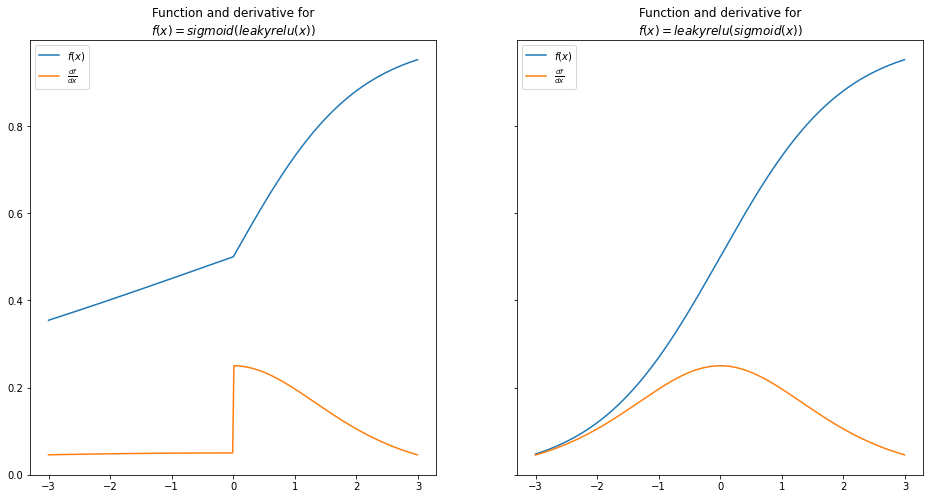

In [11]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16, 8))  # 2 Rows, 1 Col

chain_1 = [leaky_relu, sigmoid]
chain_2 = [sigmoid, leaky_relu]

PLOT_RANGE = np.arange(-3, 3, 0.01)
plot_chain(ax[0], chain_1, PLOT_RANGE)
plot_chain_deriv(ax[0], chain_1, PLOT_RANGE)

ax[0].legend(["$f(x)$", "$\\frac{df}{dx}$"])
ax[0].set_title("Function and derivative for\n$f(x) = sigmoid(leakyrelu(x))$")

plot_chain(ax[1], chain_2, PLOT_RANGE)
plot_chain_deriv(ax[1], chain_2, PLOT_RANGE)
ax[1].legend(["$f(x)$", "$\\frac{df}{dx}$"])
ax[1].set_title("Function and derivative for\n$f(x) = leakyrelu(sigmoid(x))$");

Now let's go back to our example.  Find the derivatives of L in respect to X and W can be written as follows:

$$ \frac{\partial \Lambda}{\partial u}(X) = 
\frac{\partial \nu}{\partial X}(X, W) *
\frac{\partial \sigma}{\partial u}(N) *
\frac{\partial \Lambda}{\partial u}(S) $$

Last term is the easiest.  We want to know how much L will increase if each element of S increases.  Since L is the sum of all the element of S, this derivative is simply:

$$ \frac{\partial \Lambda}{\partial u}(S) = \begin{bmatrix}
1 & 1\\
1 & 1\\
1 & 1
\end{bmatrix} $$

Second term is also easy.  It is simply:

$$ \frac{\partial \sigma}{\partial u}(N) = \begin{bmatrix}
\frac{\partial \sigma}{\partial u}(XW_{11}) &
\frac{\partial \sigma}{\partial u}(XW_{12}) \\
\frac{\partial \sigma}{\partial u}(XW_{21}) &
\frac{\partial \sigma}{\partial u}(XW_{22}) \\
\frac{\partial \sigma}{\partial u}(XW_{31}) &
\frac{\partial \sigma}{\partial u}(XW_{32})
\end{bmatrix} $$

Now, we can already find the product of second and last term which is:

$$ \frac{\partial \Lambda}{\partial u}(N) = 
\frac{\partial \Lambda}{\partial u}(S) *
\frac{\partial \sigma}{\partial u}(N) =  \begin{bmatrix}
\frac{\partial \sigma}{\partial u}(XW_{11}) &
\frac{\partial \sigma}{\partial u}(XW_{12}) \\
\frac{\partial \sigma}{\partial u}(XW_{21}) &
\frac{\partial \sigma}{\partial u}(XW_{22}) \\
\frac{\partial \sigma}{\partial u}(XW_{31}) &
\frac{\partial \sigma}{\partial u}(XW_{32})
\end{bmatrix} $$

How about $$ \frac{\partial \nu}{\partial X}(X, W) $$ and $$ \frac{\partial \nu}{\partial W}(X, W) $$

This is asking how much increasing each element of X will increase each element of N.  Same for W on N.  Since N is simply a function of dot product of X and W, the gradient is magically simple as follows:

$$ \frac{\partial \nu}{\partial X}(X, W) = W^T $$

$$ \frac{\partial \nu}{\partial W}(X, W) = X^T $$

Thus, 

$$ \frac{\partial \Lambda}{\partial u}(X) = 
\frac{\partial \Lambda}{\partial u}(S) * 
\frac{\partial \sigma}{\partial u}(N) *
W^T
$$

$$ 
\frac{\partial \Lambda}{\partial u}(W) = X^T *
\frac{\partial \Lambda}{\partial u}(S) * 
\frac{\partial \sigma}{\partial u}(N) $$

The math looks confusing, but the code is actually pretty simple

In [12]:
def forward(X: ndarray,W: ndarray) -> float:
    assert X.shape[1] == W.shape[0]

    N = np.dot(X, W)
    S = sigma(N)
    L = np.sum(S)

    return L

In [13]:
def forward_backward(X: ndarray,W: ndarray) -> float:
    assert X.shape[1] == W.shape[0]

    N = np.dot(X, W)
    S = sigma(N)
    L = np.sum(S)
    
    # dLdS - just 1s
    dLdS = np.ones_like(S)

    # dSdN
    dSdN = deriv(sigma, N)
    
    # dLdN
    dLdN = dLdS * dSdN

    # dNdX
    dNdX = W.T
    #dNdW = X.T

    # dLdX
    dLdX = np.dot(dSdN, dNdX)
    #dldW = np.dot(dNdW, dSdN)

    return dLdX

In [14]:
print("X:")
print(X)

print("L:")
print(round(forward(X, W), 4))
print("dLdX:")
print(forward_backward(X, W))

X:
[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]]
L:
3.067
dLdX:
[[ 0.03685663 -0.05665209 -0.6691846 ]
 [-0.02524588 -0.01606117 -0.72432314]
 [-0.027645   -0.0145585  -0.72786339]]


In [15]:
X1 = X.copy()

#if we increase X by 0.001
X1[0, 0] += 0.001

#then L should increase by 0.001 x 0.0369.   If we divide by 0.001, we should see the 0.0369
round((forward(X1, W) - forward(X, W))/0.001, 4)

0.0369

### Linear Regression as Neural Network

In the last section, we have learned roughly the basic components of neural network.  Let's put them further and implement linear regression as neural network.  Linear regression is a good example since it is something we already understand and would be perfect example to see how neural network in the most basic form, is actually linear regression!

Given the following neural network for linear regression:

![](figures/linearneuralnet.png)

Code can be simply written as follows:

In [16]:
from typing import Callable, Dict, Tuple, List

def forward(X: ndarray, y: ndarray,
            weights: Dict[str, ndarray]
           )-> Tuple[float, Dict[str, ndarray]]:
    '''
    Forward pass for the step-by-step linear regression.
    '''
    # assert batch sizes of X and y are equal
    assert X.shape[0] == y.shape[0]

    # assert that matrix multiplication can work
    assert X.shape[1] == weights['W'].shape[0]

    # assert that B is simply a 1x1 ndarray
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1

    # compute the operations on the forward pass
    N = X @ weights['W']

    P = N + weights['B']

    loss = np.mean(np.power(y - P, 2))

    # save the information computed on the forward pass
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

#### Calculating gradients

The next step is to train the model using gradient descent.  To calculate the gradient, we simply apply chain rule and multiply their products together.  The main derivatives we need is $ \frac{\partial \Lambda}{\partial W}$ and $ \frac{\partial \Lambda}{\partial B}$  where 

$$ \frac{\partial \Lambda}{\partial W} = 
    \frac{\partial \Lambda}{\partial P}(P, Y) *
    \frac{\partial \alpha}{\partial N}(N, B) *
    \frac{\partial \nu}{\partial W}(X, W)
$$

and 

$$ \frac{\partial \Lambda}{\partial B} = 
    \frac{\partial \Lambda}{\partial P}(P, Y) *
    \frac{\partial \alpha}{\partial B}(N, B)
$$

![](figures/linearneuralnet2.png)

Since $$ \Lambda(P, Y) = (Y - P)^2 $$, thus

$$ \frac{\partial \Lambda}{\partial P}(P, Y) = 
-1 * (2 * (Y - P)^2
$$

Next, for $$ \frac{\partial \alpha}{\partial N}(N, B) $$

Since $\alpha$ is simply addition, increasing any element of N by one unit will increase N + B by one unit, thus $$ \frac{\partial \alpha}{\partial N}(N, B) $$ is simply a list of ones with shape of N like:

<code>dPdN = np.ones_like(N) </code>

Similarly, $$ \frac{\partial \alpha}{\partial B}(N, B) $$ is simply a list of ones with shape of B like:

<code>dPdB = np.ones_like(B) </code>

Last, we have $$ \frac{\partial \nu}{\partial W}(X, W) $$  This is easy as we know already that 

$$ \frac{\partial \nu}{\partial W}(X, W) = X^T $$ 

Thus

$$ \frac{\partial \nu}{\partial W}(X, W) $$

Now, without further do....let's code right now!

In [17]:
def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:

    dLdP = -2 * (forward_info['y'] - forward_info['P'])

    dPdN = np.ones_like(forward_info['N'])

    dPdB = np.ones_like(weights['B'])

    dLdN = dLdP * dPdN

    dNdW = forward_info['X'].T
    
    # need to use matrix multiplication here,
    # with dNdW on the left    
    dLdW = dNdW @ dLdN

    # need to sum along dimension since b is added to every row   
    dLdB = (dLdP * dPdB).sum(axis=0)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB

    return loss_gradients

#### Putting everything together into a train method

To combine the loss_gradients and forward into a single train method, as well as some shuffling, we can do as follows:

In [18]:
def init_weights(n_in: int) -> Dict[str, ndarray]:
    '''
    Initialize weights on first forward pass of model.
    '''
    
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B

    return weights

In [19]:
def train(X: ndarray, 
          y: ndarray, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False) -> None:
    
    np.random.seed(42)
    start = 0

    #initialize randomom weights
    weights = init_weights(X.shape[1])

    # Permute data
    perm = np.random.permutation(X.shape[0])
    X, y = X[perm], y[perm]
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        # in case all data is used
        if start >= X.shape[0]:
            perm = np.random.permutation(X.shape[0])
            X, y = X[perm], y[perm]
            start = 0
        
        #reduce batch size if exceeds
        if start+batch_size > X.shape[0]:
            batch_size = X.shape[0] - start
    
        X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        
        #loss_grads and weights have same keys
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, weights
    
    return None

#### Let's test our model

In [20]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

boston = load_boston()
X = boston.data
y = boston.target
features = boston.feature_names
s = StandardScaler()
X = s.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#since our train function assumes y to be shape of (n, 1)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [21]:
train_info = train(X_train, y_train,
                   n_iter = 10000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True)
losses = train_info[0]
weights = train_info[1]

In [22]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]):
    
    N = X @ weights['W']

    return N + weights['B']

In [23]:
y_pred = predict(X_test, weights)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("$R^2$: ", r2_score(y_test, y_pred))

MSE:  21.962219458334552
$R^2$:  0.7052569177141323


Let's plot the actual vs. predicted values

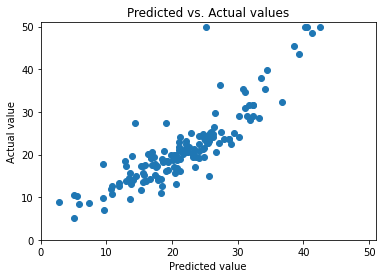

In [24]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(y_pred, y_test)

#### Importance of each feature

As we already know, we can check the size of coefficients to know which one is important

In [25]:
weights['W']

#so which one is the most important feature?

array([[-1.21213267],
       [ 0.81433624],
       [ 0.30894756],
       [ 0.84788429],
       [-1.78763297],
       [ 2.87254465],
       [-0.2811529 ],
       [-2.9113813 ],
       [ 2.12380982],
       [-1.34482524],
       [-1.90944831],
       [ 1.14951932],
       [-4.008822  ]])

#### Compare with sklearn

To make sure our code from scratch is correct, let's compare with sklearn

In [26]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("$R^2$: ", r2_score(y_test, y_pred))

MSE:  21.517444231177276
$R^2$:  0.7112260057484923


### Improved model: Neural Network

As we see from above, the score is not really nice.  One possibility is due to the linear assumption of linear regression.  We may be able to improve the accuracy if we can deploy a non-linear model.  Here we shall modify linear regression to non-linear form in the neural network.  Here we shall further clearly see that adding non-linearity is basically adding more activation functions!   In fact, you will be surprised that neural network, at its most basic form, is actually a linear regression!

#### Step 1: Adding many linear regressions

In one linear regression. if our X had dimensions <code>[batch_size, num_features]</code>, then we multiplied it by a weight matrix W with dimensions <code>[num_features, 1]</code> to get an output of dimension <code>[batch_size, 1]</code>; this output is, for each observation in the batch, simply a weighted sum of the original features. 

To do multiple linear regressions, we’ll simply multiply our input by a weight matrix with dimensions <code>[num_features, num_outputs]</code>, resulting in an output of dimensions <code>[batch_size, num_outputs]</code>; now, for each observation, we have multiple (num_outputs) different weighted sums of the original features.

#### Step 2: A non-linear function

Next, we’ll feed each of these weighted sums through a nonlinear function; the first function we’ll try is the sigmoid function

Why is using this nonlinear function a good idea? Why not the square function f(x) = $x^2$, for example? There are a couple of reasons. First, we want the function we use here to be monotonic so that it “preserves” information about the numbers that were fed in. Let’s say that, given the date that was fed in, two of our linear regressions produced values of –3 and 3, respectively. Feeding these through the square function would then produce a value of 9 for each, so that any function that receives these numbers as inputs after they were fed through the square function would “lose” the information that one of them was originally –3 and the other was 3.

The second reason, of course, is that the function is nonlinear; this nonlinearity will enable our neural network to model the inherently nonlinear relationship between the features and the target.

Finally, the sigmoid function has the nice property that its derivative can be expressed in terms of the function itself:

$$ \frac{\partial \sigma}{\partial u}(x) = \sigma(x) * (1 - \sigma(x)) $$

#### Step 3: Add another linear regression

Finally, we’ll take the resulting 13 elements—each of which is a combination of the original features, fed through the sigmoid function so that they all have values between 0 and 1—and feed them into a regular linear regression, using them the same way we used our original features previously.

Then, we’ll try training the entire resulting function in the same way we trained the standard linear regression earlier in this chapter: we’ll feed data through the model, use the chain rule to figure out how much increasing the weights would increase (or decrease) the loss, and then update the weights in the direction that decreases the loss at each iteration. Over time (we hope) we’ll end up with a more accurate model than before, one that has “learned” the inherent nonlinearity of the relationship between our features and our target.”


Finally, consider the following network:

![](figures/neuralnet2.png)

Let's code them accordingly:

Starting with the sigmoid function:

In [27]:
def sigmoid(x: ndarray) -> ndarray:
    return 1 / (1 + np.exp(-1.0 * x))

#### Let's start coding

In [28]:
#since our weights will depend on the size of nonlinearity,
#we can num_outputs as hidden_size
def init_weights(input_size: int, 
                 hidden_size: int) -> Dict[str, ndarray]:
    weights: Dict[str, ndarray] = {}
    weights['W1'] = np.random.randn(input_size, hidden_size)
    weights['B1'] = np.random.randn(1, hidden_size)
    weights['W2'] = np.random.randn(hidden_size, 1)
    weights['B2'] = np.random.randn(1, 1)
    return weights

In [29]:
#similar as before
def forward(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]
                 ) -> Tuple[Dict[str, ndarray], float]:

    M1 = X @ weights['W1']

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)
    
    M2 = O1 @ weights['W2']

    P = M2 + weights['B2']    

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['M1'] = M1
    forward_info['N1'] = N1
    forward_info['O1'] = O1
    forward_info['M2'] = M2
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

For the gradients, the figure looks like this:
    
![](figures/gradient2.png)

In [30]:
def loss_gradients(forward_info: Dict[str, ndarray], 
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
 
    #remove constant does not change the direction
    dLdP = -(forward_info['y'] - forward_info['P'])
    
    dPdM2 = np.ones_like(forward_info['M2'])
    
    dPdB2 = np.ones_like(weights['B2'])

    dLdM2 = dLdP * dPdM2
  
    dLdB2 = (dLdP * dPdB2).sum(axis=0)
    
    dM2dW2 = forward_info['O1'].T
    
    dM2dO1 = weights['W2'].T
    
    dLdW2 = dM2dW2 @ dLdP

    dLdO1 = dLdM2 @ dM2dO1
    
    dO1dN1 = sigmoid(forward_info['N1']) * (1- sigmoid(forward_info['N1']))
    
    dLdN1 = dLdO1 * dO1dN1
    
    dN1dB1 = np.ones_like(weights['B1'])
    
    dN1dM1 = np.ones_like(forward_info['M1'])
    
    dLdB1 = (dLdN1 * dN1dB1).sum(axis=0)
    
    dLdM1 = dLdN1 * dN1dM1
    
    dM1dW1 = forward_info['X'].T 

    dLdW1 = dM1dW1 @ dLdM1

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W2'] = dLdW2
    loss_gradients['B2'] = dLdB2.sum(axis=0)
    loss_gradients['W1'] = dLdW1
    loss_gradients['B1'] = dLdB1.sum(axis=0)
    
    return loss_gradients

Our train method looks very unchanged...except adding the hidden size parameter

In [31]:
def train(X: ndarray, 
          y: ndarray, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False,
          hidden_size = 13) -> None:
    
    np.random.seed(42)
    start = 0

    #initialize randomom weights
    weights = init_weights(X_train.shape[1], hidden_size = hidden_size)

    # Permute data
    perm = np.random.permutation(X.shape[0])
    X, y = X[perm], y[perm]
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        # in case all data is used
        if start >= X.shape[0]:
            perm = np.random.permutation(X.shape[0])
            X, y = X[perm], y[perm]
            start = 0
        
        #reduce batch size if exceeds
        if start+batch_size > X.shape[0]:
            batch_size = X.shape[0] - start
    
        X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        
        #loss_grads and weights have same keys
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, weights
    
    return None

Since our network change, we also need to revise our predict method slightly:

In [32]:
def predict(X: ndarray, 
            weights: Dict[str, ndarray]) -> ndarray:

    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)

    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']    

    return P

Let's train model

In [33]:
train_info = train(X_train, y_train,
                   n_iter = 10000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True)
losses = train_info[0]
weights = train_info[1]

Here is the prediction accuracy:

In [34]:
y_pred = predict(X_test, weights)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("$R^2$: ", r2_score(y_test, y_pred))

MSE:  10.839123211769357
$R^2$:  0.8545339831990069


### Conclusion

We can learn several things here:
1. Non-linearity in the sigmoid function helps improve the performance
2. The math behind neural network, in fact, is much simpler than some traditional models!  It relies only the chain rule to derive the gradients of L in respect to W and B
3. Neural network, on its simplest form, is simply a linear regression.  In simple word, neural work can be seen as simply linear combinations of X.  But if we introduce sigmoid or other functions, it become non-linear
4. Key thing I want to focus is not on the programing side.  In fact, coding from scratch is mainly for the purpose of understanding neural network from ground up.  It is my intention that once you understand them, you can build on of your own in your research in the future.  Who knows some genius could be hiding here!